In [1]:
import numpy as np
import math
from pprint import pprint
from itertools import permutations
import itertools
import pylab
import matplotlib.path
import matplotlib.pyplot as plt
import json
import pandas as pd
import copy

идея с подозрительными точками которые можно выкинуть из распознавания кажется мне лишней, тк это усложняет алгоритм проверками на количество апдейтов и добавляет лишний список, когда ложные тачи сами по себе быстро исчезают как правило.

# Класс тачей для геометрических манипуляций

In [2]:
class Cursor:
    def __init__(self, cursor_dict):
        self.ID = cursor_dict.get('id', None)
        self.x = cursor_dict.get('Position',{}).get('X')
        self.y = cursor_dict.get('Position', {}).get('Y')
        self.type = cursor_dict.get('type', None)

    # function to add two vectors
    def __add__(self, other):
        return Cursor({'Position':{'X':self.x+other.x, 'Y':self.y+other.y}})

    # function to subtract vectors
    def __sub__(self, other):
        return Cursor({'Position':{'X':self.x-other.x, 'Y':self.y-other.y}})

    # make the vector printable
    def __repr__(self):
        return "ID%s (%s, %s) type %s;" % (self.ID, self.x, self.y, self.type)
    
    # calculate distance from (0,0)
    def length(self):
        return np.linalg.norm([self.x, self.y])
    
    # calc unit vector
    def unit_vector(self):
        length = self.length()
        return Cursor({'Position':{'X':self.x/length, 'Y':self.y/length}})
    
    def update_state(self, x, y, state_type):
        self.x = x
        self.y = y
        self.type = state_type

In [3]:
# function to calculate the distance between two points
def distance(p1, p2):
    dist = np.linalg.norm([p2.x - p1.x, p2.y - p1.y])
    return dist

# calc dot product of two vectors
def dot_product(v1, v2):
    return np.dot([v1.x, v1.y], [v2.x, v2.y])

#returns the angle in radians between vectors 'v1' and 'v2'
def calc_angle(v1, v2, deg=False):
    #print('Первый вектор:', v1)
    #print('Второй вектор:', v2)
    radians = np.arccos(np.clip(dot_product(v1.unit_vector(), v2.unit_vector()), -1.0, 1.0))
    result = radians
    if deg:
        result = np.degrees([radians.real])[0]  # переводим в градусы
    print('угол:', result)
    return result

# function to rotate a vector by a certain angle
def rotate_vector(vec, angle, deg=False):
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    rotated_vector =Cursor({'Position':{'X':vec.x*cos_angle - vec.y*sin_angle, 'Y':vec.x*sin_angle + vec.y*cos_angle}})
    return rotated_vector

# function to calculate the clockwise difference between two angles
def clockwise_difference_between_angles(original_angle, changed_angle, deg=False):
    if original_angle > changed_angle:
        changed_angle += 2*math.pi
    angle = changed_angle - original_angle
    return angle

# function to check if a point lies in a circle 
def is_point_in_circle(center, radius, point):
    distance_from_center = distance(center, point)
    return distance_from_center <= radius

# Класс треугольника 

In [4]:
class Triangle:
   
    # The side between vertices 1 and 2 has to be the shortest side
    # The side between vertices 2 and 3 has to be he intermediate side
    # The side between vertices 3 and 1 has to be the longest side
    
    
    # function calculate the side lengths and orientation of the trinagle
    def __init__(self, p1, p2, p3):
        #print("triangle", p1, p2)
        
        points_sides = self.arrange_sides(p1, p2, p3)
        #print(points_sides)
        self.v1 = points_sides['v1']
        self.v2 = points_sides['v2']
        self.v3 = points_sides['v3']
        self.long_side = points_sides['a']
        self.middle_side = points_sides['b']
        self.short_side = points_sides['c']
        
        # check for rotation order (v2 left or right of v1 to v3)
        if ((self.v3.x - self.v1.x)*(self.v2.y - self.v1.y) - (self.v3.y - self.v1.y)*(self.v2.x - self.v1.x)) > 0:
            self.clockwise_rotation = True
        else:
            self.clockwise_rotation = False
           
        #self.center = None
        #self.radius = None
        
    # function calculate the side lengths
    
    def arrange_sides(self, p1, p2, p3):
        # get the length of the triangle sides and put them in order
        a = distance(p1, p2) + 0.000000001 # prevent same size sides
        b = distance(p2, p3)
        c = distance(p3, p1)- 0.000000001 # prevent same size sides

        # return [v1, v2, v3, long_side, middle_side, short_side]

        if (a > b) & (a > c):
            # a is longest
            if b > c:
                # b is middle
                # c is shortest
                return {'v1':p1, 'v2':p3, 'v3':p2, 'a':a, 'b':b, 'c':c}
            else:
                # c is middle
                # b is shortest
                return {'v1':p2, 'v2':p3, 'v3':p1, 'a':a, 'b':c, 'c':b} #[p2, p3, p1, a, c, b]

        elif (b > a) & (b > c):
            # b is longest
            if a > c:
                # a is middle
                # c is shortest
                return {'v1':p3, 'v2':p2, 'v3':p2, 'a':b, 'b':a, 'c':c} #[p3, p1, p2, b, a, c]
            else:
                # c is middle
                # a is shortest
                return {'v1':p2, 'v2':p1, 'v3':p3, 'a':b, 'b':c, 'c':a} #[p2, p1, p3, b, c, a]

        elif (c > a) & (c > b):
            # c is longest
            if a > b:
                # a is middle
                # b is shortest
                return {'v1':p3, 'v2':p2, 'v3':p1, 'a':c, 'b':a, 'c':b} #[p3, p2, p1, c, a, b]

            else:
                # b is middle
                # a is shortest
                return {'v1':p1, 'v2':p2, 'v3':p3, 'a':c, 'b':b, 'c':a}
                

    # function to print a fancy info about the triangle to console
    def pretty_print(self):
        print('\n--------Triangle -------------------\n')
        print('v1:', self.v1)
        print('v2:', self.v2)
        print('v3:', self.v3)
        print('Longest side v3-v1:', self.long_side)
        print('Middle side v2-v3:', self.middle_side)
        print('Shortest side v1-v2:', self.short_side)
        if self.clockwise_rotation:
            print ('Middle side is counter clockwise oriented')
            print('clockwise_rotation')
        else:
            print ('Middle side is clockwise oriented')
            print('counter clockwise_rotation')
            
    def draw_triangle(self):
        xy = np.array([[self.v1.x, self.v1.y], [self.v2.x, self.v2.y], [self.v3.x, self.v3.y]])
        xs = xy[:, 0]
        ys = xy[:, 1]
        plt.figure()
        plt.scatter(xs, ys, s=0.001, color='red')

        triangle = plt.Polygon(xy, color='red', fill=0)
        plt.gca().add_patch(triangle)
        plt.xlim(0, 1)
        plt.ylim(0, 0.5625)
        #plt.savefig('example.pdf')
        plt.show()     

In [8]:
# function to create all possible triangles from a list of points 
# создание всевозможных треугольников из списка точек

def create_triangles_from_cursors(list_of_cursors):
    
    triangles = []
    
    # create  tuples with the length of 3 points, in sorted order, no repeated elements
    for combination in list(itertools.combinations(list_of_cursors.values(), 3)):
        # create triangles from the tuples
        t = Triangle(combination[0], combination[1], combination[2])
        if t.long_side<LIMIT_DISTANCE:
            triangles.append(t)
    return triangles

# function to compare two triangles on their similarity
# сравнение двух треугольников с учетом погрешности
tolerance = EPS

def compare_triangles(t1, t2, tolerance=EPS):
    
    # check if both triangles have the same rotation
    if t1.clockwise_rotation == t2.clockwise_rotation:
        # check if the difference of the long sides is within tolerance
        long_side_difference = math.fabs(t1.long_side - t2.long_side)
        
        if long_side_difference <= tolerance:
            # check if the difference of the middle sides is within tolerance
            middle_side_difference = math.fabs(t1.middle_side - t2.middle_side)
            
            if middle_side_difference <= tolerance:
                # check if the difference of the short sides is within tolerance
                short_side_difference = math.fabs(t1.short_side - t2.short_side)
                
                if short_side_difference <= tolerance: 
                    # triangles are considered equal
                    # return mean error
                    return np.mean(np.array([long_side_difference,
                                            middle_side_difference,
                                            short_side_difference]))
    # triangles are considered different
    return None

# Класс маркера

In [9]:
class Marker(Triangle):
    def __init__(self, p1, p2, p3, ID):
        super().__init__(p1, p2, p3)
        self.ID = ID
        self.center = None
        self.radius = None
        
        try:
            self.set_center_and_radius()
        except Exception:
            print('cant find center')
        
    # если обновлять только положение центра на рисунке а радиус оставить как при инициализации
    def update_center(self):
        # используя линал (строим две прямые проходящие через три точки) 
        # пересечение перпендикуляров это координаты центра окружности
        
        if self.v2.x-self.v1.x == 0:
            # count p2p3 p3p1
            self.center = self.find_center(self.v2, self.v3, self.v1)
            
        if self.v3.x-self.v2.x == 0:
            # count p3p1 p1p2
            self.center = self.find_center(self.v3, self.v1, self.v2)
            
        else:
            self.center = self.find_center(self.v1, self.v2, self.v3)
    
    
    def set_center_and_radius(self):
        self.update_center() 
        #по коорд центра выч радиус
        self.radius = distance(self.v1, self.center)
        
    def find_center(self, v1, v2, v3):
        m_a = (v2.y-v1.y) / (v2.x-v1.x)
        m_b = (v3.y-v2.y) / (v3.x-v2.x)
        x_center = (m_a*m_b*(v1.y-v3.y) + m_b*(v1.x+v2.x) - m_a*(v2.x+v3.x)) / (2*(m_b-m_a))
        y_center = -1/m_a * (x_center-(v1.x+v2.x)/2) + (v1.y+v2.y)/2
        return Cursor({'Position':{'X':x_center, 'Y':y_center}})
        
    def draw_circle_marker(self):
        try:
            pylab.xlim(0,1)
            pylab.ylim(0,0.5625)
            pylab.grid()

            axes = pylab.gca()
            axes.set_aspect("equal")

            circle = pylab.Circle((self.center.x, self.center.y), radius=self.radius, fill=False, color="r")
            axes.add_patch(circle)
            pylab.text (self.center.x, self.center.y+self.radius, self.ID, horizontalalignment="center")

            center = pylab.Circle((self.center.x, self.center.y), radius=0.005, fill=True)
            axes.add_patch(center)

            p1 = pylab.Circle((self.v1.x, self.v1.y), radius=0.005, fill=True)
            axes.add_patch(p1)

            p2 = pylab.Circle((self.v2.x, self.v2.y), radius=0.005, fill=True)
            axes.add_patch(p2)

            p3 = pylab.Circle((self.v3.x, self.v3.y), radius=0.005, fill=True)
            axes.add_patch(p3)

            pylab.show()
            
        except Exception:
            print('cant find center')

# Работа с реальными данными

### СТАРЫЕ ДАННЫЕ С ДОМНОЖЕНИЕМ: ПЕРЕМЕЩЕНИЕ

- среднее отклонение сторона 1: 0.0007365440852555339
- среднее отклонение сторона 2: 0.0008687806185649966
- среднее отклонение сторона 3: 0.0008373487734109106
- mean side1: 0.059430867284932985
- mean side2: 0.046497129637034666
- mean side3: 0.046442863676472046
- max-min 1: 0.007692202458751657
- max-min 2: 0.009430412346614278
- max-min 3: 0.01044698446368151

### СТАРЫЕ ДАННЫЕ С ДОМНОЖЕНИЕМ: ВРАЩЕНИЕ

- среднее отклонение сторона 1: 0.0006923971043760339
- среднее отклонение сторона 2: 0.00046456426245271423
- среднее отклонение сторона 3: 0.0006644647406281697
- mean side1: 0.05908295398495471
- mean side2: 0.04618482031271678
- mean side3: 0.0465777259577589
- max-min 1: 0.01315193733704667
- max-min 2: 0.00379126182089648
- max-min 3: 0.004435597195867169

### СТАРЫЕ ДАННЫЕ С ДОМНОЖЕНИЕМ: ПЕРЕМЕЩЕНИЕ И ВРАЩЕНИЕ

- среднее отклонение сторона 1: 0.0011302658776727753
- среднее отклонение сторона 2: 0.0010504614690109834
- среднее отклонение сторона 3: 0.0009403966319318907
- mean side1: 0.05900941255420931
- mean side2: 0.04700168495373052
- mean side3: 0.04599806431568284
- max-min 1: 0.009565616812170087
- max-min 2: 0.00941518289333601
- max-min 3: 0.009536065709587753

Исходя из данных полученных с рамки, расстояния между точками иаркера можно ограничить сверху:

$LIMIT DISTANCE = 0.07$

А ошибку (модуль среднего отклонения):

$EPS = 0.002$

In [6]:
LIMIT_DISTANCE = 0.09  #см. Это диаметр маркера
EPS = 0.01 #см. Насколько точно рамка определяет положение ножек маркера?

ф-я для считывания данных сессии (из файла надо удалить первую строку)

# Вариант с ID

# Данные

In [10]:
# считываем данные сессии
def read_data(file_name='touchpoints.txt'):
    touchs = []
    with open(file_name, 'r') as f:
        for line in f.readlines():
            touchs.append(json.loads(line))
    return touchs

In [11]:
# достаем данные о тачах - список словарей вида см. ниже
def get_touchs_data(file_name='1marker/touchpoints.txt'):
    touchs = read_data(file_name)
    df = pd.DataFrame(touchs) 
    return df['touches']

[
{'Acceleration': {'X': 0.0046875, 'Y': 0.00462962966},
'Position': {'X': 0.508854151, 'Y': 0.687037051},
'id': 0,
'type': 1},
  
  
 {'Acceleration': {'X': 0.004166667, 'Y': 0.00648148125},
 'Position': {'X': 0.469270825, 'Y': 0.6064815},
 'id': 1,
 'type': 1},
  
  
 {'Acceleration': {'X': 0.00364583335, 'Y': 0.00370370364},
 'Position': {'X': 0.4625, 'Y': 0.687962949},
 'id': 2,
 'type': 1}
  ]

In [33]:
raw_df = get_touchs_data()

In [35]:
# точки которые отправляются в алгоритм для распознавания id_cursor: cursor_dict
valid_cursors = {}

# чтобы знать какие точки для какого маркера id_cursor: (marker_name, vertex)
markers_cursors = {}

# id_marker: marker  нужно для сохранения начального положения? (пока не используется)
recognized_markers = {}

# маркер на столе (не нужно распознавать) id_cursor: (marker_name, vertex)
active_markers = {}

In [13]:
problem_markers = {}

In [15]:
# зарегестрированный маркер, но которого нет на столе (используется в распознавании)
passive_markers = {}

По полю type можно понять состояние тача: 0 DOWN, 1 NOTHING, 2 UP

В случае появления нового, сразу обновляем список тачей с которыми будем работать

Возвращаем список пропавших тачей

In [16]:
# масштабируем координату по y
def scale_y_touch(touch):
    scaled_touch = touch.copy()
    scaled_touch['Position']['Y'] = scaled_touch['Position']['Y']*0.5625
    return scaled_touch

In [17]:
def update_state_for_all_lists(ID, scaled_touch, valid_cursors, markers_cursors, active_markers):
    #updated_markers = []
    marker_name = None
    
    x = scaled_touch.get('Position',{}).get('X')
    y = scaled_touch.get('Position',{}).get('Y')
    state_type = scaled_touch.get('type', None)
    if ID in valid_cursors.keys():
        valid_cursors[ID].update_state(x, y, state_type)
    elif ID in markers_cursors.keys():
        
        marker_name, vertex = markers_cursors[ID]
        if vertex == 'v1':
            active_markers[marker_name].v1.update_state(x, y, state_type)
        elif vertex == 'v2':
            active_markers[marker_name].v2.update_state(x, y, state_type)
        else:
            active_markers[marker_name].v3.update_state(x, y, state_type)
        #active_markers[marker_name].update_center()
        
    return marker_name

In [20]:
# тач-курсор, распределяем по спискам в заыисимости от типа
def filter_touchs(touchs_data_from_frame, valid_cursors):
    
    lost_touchs = []
    updated_markers = []
    
    for touch in touchs_data_from_frame:
        
        scaled_touch = scale_y_touch(touch)
        
        # новый тач кидаем в рабочий список
        if touch['type'] == 0:
            ID = touch.get('id')
            valid_cursors.update({ID:Cursor(scaled_touch)})
            
        # для старых обновляем положение
        elif touch['type'] == 1:
            ID = touch.get('id')
            updated_marker = update_state_for_all_lists(ID, scaled_touch, valid_cursors, markers_cursors, active_markers)
            if updated_marker:
                updated_markers.append(updated_marker)
            
        # собираем удаленные тачи для удаления из списков
        elif touch['type'] == 2:
            lost_touchs.append(scaled_touch)
            
    for marker_name in updated_markers:
        try:
            active_markers[marker_name].update_center()
        except Exception:
            print('cant update center') # происходит ошибка деления на ноль из-за маленьких значений
            
    return lost_touchs

In [18]:
# так как даже если потерянный тач очень быстро вернется на место - для рамки это уже будет новый тач с возможно новым id
# поэтому нет смысла его хранить, мы просто не сможем определить что именно он вернулся

# могу предложить при утере 1-2 тачей от маркера оставлять его неподвижным, до тех пор пока остальные не вернутся - это можно

def delete_lost_cursors(lost_touchs, valid_cursors, markers_cursors, passive_markers, active_markers, problem_markers):
    
    # это маркеры у которых потеряна ножка
    bad_markers = []
    for touch in lost_touchs:
        ID = touch['id']
        if ID in valid_cursors.keys():
            valid_cursors.pop(ID)
        
        ## Надо отправить сломанный маркер на рекогнишн чтобы словить утерянный тач 
        
        # если утеряный тач одна из вершин маркера, то в случае если мы еще не расформировали этот маркер
        # из-за другого утерянного тача из этого же маркера нужно перекинуть оставшиеся вершины (not UP) в валидный список
        # добавляем маркер в список распознавания и удаляем из активного
        
        ## может получиться так что сначала оторвалась одна ножка затем две другие и мы не поймем что застывший маркер
        # больше не надо отображать 
        
        elif ID in markers_cursors.keys():
            marker_name = markers_cursors[ID][0]
            # если еще не встречался оторванный тач из того же маркера, переносим оставшиеся 
            # неудаляемые точки маркера на распознавание 
            if marker_name not in bad_markers:
                # маркер с оторванной ножкой/ами больше не активный
                lost_marker = active_markers.pop(marker_name)
                if marker_name not in problem_markers.keys():
                    # его нет в проблем маркер значит ножка отрывается первый раз/ первая ножка
                       
                    count_lost_vertex = 0

                    count_lost_vertex += add_marker_vertex_to_valid(lost_marker.v1, valid_cursors)
                    count_lost_vertex += add_marker_vertex_to_valid(lost_marker.v2, valid_cursors)
                    count_lost_vertex += add_marker_vertex_to_valid(lost_marker.v3, valid_cursors)
                    
                    if count_lost_vertex <= 1:
                        problem_markers[marker_name] = lost_marker
                    #else:
                        # маркеру хана
                        
                        
                #else:
                    # маркер уже есть в проблем маркер значит оторвалась уже 2-3 ножка -- ему хана
                    
                    
                # активный маркер расформировываем и добавляем в пассивный
                # в любом слуяае отправляем маркер на распознавание 1 раз
                passive_markers[marker_name] = lost_marker
            # но каждую вершину удаляем из принадлежащих меркеру
            markers_cursors.pop(ID)
    
            
def add_marker_vertex_to_valid(vertex, valid_cursors):
    delete_vertex = 1
    if vertex.type != 2:       
        valid_cursors.update({vertex.ID: vertex})
        delete_vertex = 0
    return delete_vertex  

# Симуляция сессии из файлика

# Типа зарегали

In [21]:
for update in raw_df[:130]:
    lost_touchs = filter_touchs(update, valid_cursors)

In [22]:
test_marker = Marker(valid_cursors[0], valid_cursors[1], valid_cursors[2], 'test_marker')

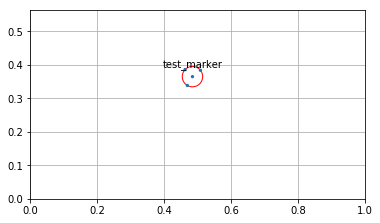

In [23]:
test_marker.draw_circle_marker()

In [24]:
passive_markers[test_marker.ID] = test_marker

In [25]:
valid_cursors = {}

In [26]:
test_marker.pretty_print()


--------Triangle -------------------

v1: ID0 (0.508854151, 0.3838541625) type 1;
v2: ID2 (0.463020831, 0.38593749374999997) type 1;
v3: ID1 (0.469791681, 0.33854169375) type 1;
Longest side v3-v1: 0.05982555061486458
Middle side v2-v3: 0.04787699100155
Shortest side v1-v2: 0.04588064297237273
Middle side is clockwise oriented
counter clockwise_rotation


In [34]:
passive_markers

{'test_marker': <__main__.Marker at 0x1105832e8>}

In [28]:
def create_cursor_by_coords(x, y):
    unit_vector_dict = {}
    unit_vector_dict['Position'] = {}
    unit_vector_dict['Position']['X']=x
    unit_vector_dict['Position']['Y']=y
    return Cursor(unit_vector_dict)

In [29]:
UNIT_VECTOR = create_cursor_by_coords(0, 1)
def marker_rotation_angle(marker, current_marker):
    old_angle = calc_angle(UNIT_VECTOR, marker.v3-marker.v1)
    new_angle = calc_angle(UNIT_VECTOR, current_marker.v3-current_marker.v1)
    result = clockwise_difference_between_angles(old_angle, new_angle)
    print("Маркер повернут на ", result, "радиан")
    return result

## Поиск маркера из списка треугольников

In [30]:
# поиск маркера среди треугольников
def choose_most_similar_marker(t_list, passive_markers, tolerance=EPS):
    
    applicants = {}
    for t in t_list:
        #t.pretty_print()
        for m in passive_markers:
            current_mean_error = compare_triangles(t, m, tolerance)
            if current_mean_error:
                if t not in applicants.keys():
                    applicants[t] = (m, current_mean_error)
                else:
                    if current_mean_error < applicants[t][1]:
                        applicants[t] = (m, current_mean_error)
    return applicants
                    #chose_most_similar_marker(, found_markers_dict[m.ID])
                #return (Marker(t.v1, t.v2, t.v3, marker.ID), current_mean_error) #+ '_current'))
            #equal_m_list.append(Marker(t.v1, t.v2, t.v3, marker.ID + '_current'))
    #return equal_m_list
    
# ищем пассивные маркеры на столе и записываем найденные в словарь
def find_all_registered_markers(passive_markers, valid_cursors):
    
    found_markers_dict = {}
    t_list = create_triangles_from_cursors(valid_cursors)
    applicants = choose_most_similar_marker(t_list, passive_markers)
    
    return [m[0] for m in applicants.values()]    
        
    #return found_markers_dict

#def choose_most_similar_marker(applicant1, applicant2):
    

In [31]:
def output_search_info(passive_markers, active_markers, markers_cursors, valid_cursors, problem_markers):
    found_markers = find_all_registered_markers(passive_markers.values(), valid_cursors)
    print("found markers:", found_markers)
    
    #if len(found_markers.keys())>1:
    #    chose
    if found_markers:
        for m in found_markers: 
            #registered_markers[m_ID].draw_circle_marker()
            print(m.ID, "RECOGNIZED!!!!!!!!!!!")
            #print('v1-v3 start:', passive_markers[m.ID].v1, passive_markers[m.ID].v3)
            
            #print('rotation angle in radians: ', marker_rotation_angle(m.ID, m))
            
            if m.ID in problem_markers.keys():
                problem_markers.pop(m.ID)
                
            
            # когда маркер распознан запихиваем вершины в список для маркеров и переносим из пассивных в активный список 
            markers_cursors[m.v1.ID] = (m.ID, 'v1')
            markers_cursors[m.v2.ID] = (m.ID, 'v2')
            markers_cursors[m.v3.ID] = (m.ID, 'v3')
            
            valid_cursors.pop(m.v1.ID)
            valid_cursors.pop(m.v2.ID)
            valid_cursors.pop(m.v3.ID)
           
            active_markers[m.ID] = passive_markers.pop(m.ID)
            
            m.draw_circle_marker()
            print('v1-v3 current:', m.v1, m.v3)
            print('offset from center: ', m.center)
            #print('deg:', np.degrees([marker_rotation_angle(registered_markers[m_ID], m).real])[0])  # переводим в градусы)

#def update_recognized_cursor(markers_cursors, valid_cursors, cursor_ID, m_ID):
   # если будет не кортеж 
    

In [32]:
def output_active_markers_info(active_markers):
    for m in active_markers.values():
        #print('v1-v3 start:', active_markers[m_ID].v1, active_markers[m_ID].v3)
        print("\nACTIVE MARKERS INFO")
        m.draw_circle_marker()
        print('v1-v3 current:', m.v1, m.v3)
        print('offset from center: ', m.center)
        #print('rotation angle in radians: ', marker_rotation_angle(active_markers[m_ID], m))

# Как будто приходят данные с рамки

found markers: [<__main__.Marker object at 0x1105832e8>]
test_marker RECOGNIZED!!!!!!!!!!!


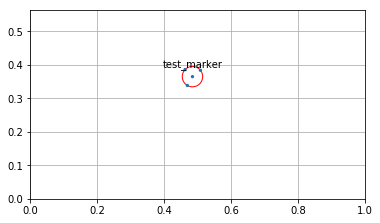

v1-v3 current: ID0 (0.508854151, 0.3838541625) type 1; ID1 (0.469791681, 0.33854169375) type 1;
offset from center:  IDNone (0.4850285874219871, 0.3648999352298066) type None;

ACTIVE MARKERS INFO


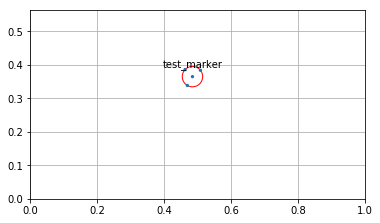

v1-v3 current: ID0 (0.508854151, 0.3838541625) type 1; ID1 (0.469791681, 0.33854169375) type 1;
offset from center:  IDNone (0.4850285874219871, 0.3648999352298066) type None;

ACTIVE MARKERS INFO


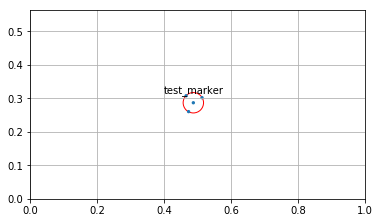

v1-v3 current: ID0 (0.513541639, 0.3020833125) type 1; ID1 (0.4734375, 0.2604166621875) type 1;
offset from center:  IDNone (0.4876576719030242, 0.28686318711163994) type None;

ACTIVE MARKERS INFO


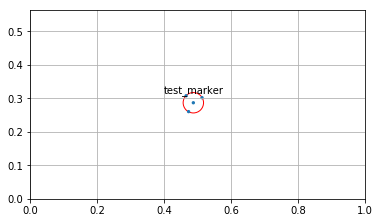

v1-v3 current: ID0 (0.513541639, 0.3020833125) type 1; ID1 (0.4734375, 0.2604166621875) type 1;
offset from center:  IDNone (0.4876576719030242, 0.28686318711163994) type None;

ACTIVE MARKERS INFO


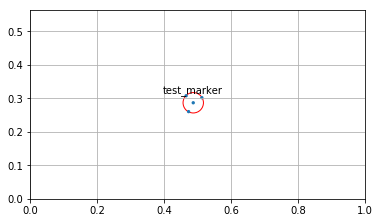

v1-v3 current: ID0 (0.5130208, 0.3020833125) type 1; ID1 (0.4734375, 0.2604166621875) type 1;
offset from center:  IDNone (0.4873675063487674, 0.2868185463087655) type None;

ACTIVE MARKERS INFO


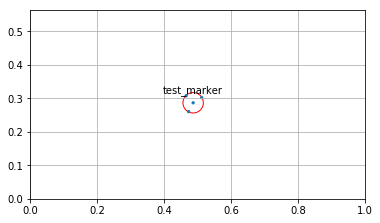

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4734375, 0.2604166621875) type 1;
offset from center:  IDNone (0.48707668118343184, 0.2867738040273809) type None;

ACTIVE MARKERS INFO


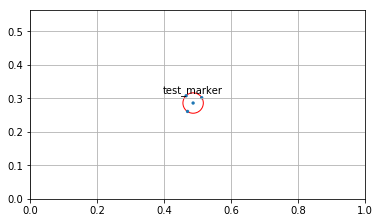

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.4869862687403309, 0.2860422863861404) type None;

ACTIVE MARKERS INFO


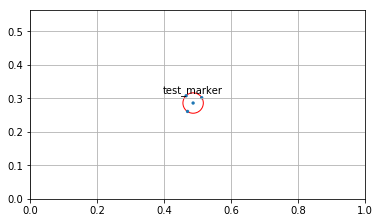

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.4869862687403309, 0.2860422863861404) type None;

ACTIVE MARKERS INFO


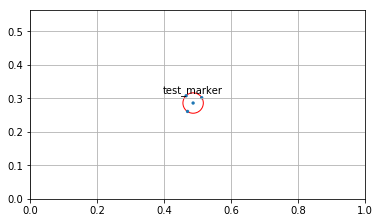

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.4869862687403309, 0.2860422863861404) type None;

ACTIVE MARKERS INFO


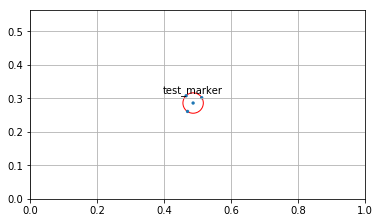

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.4869862687403309, 0.2860422863861404) type None;

ACTIVE MARKERS INFO


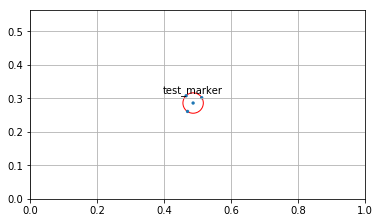

v1-v3 current: ID0 (0.5125, 0.3020833125) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.4869862687403309, 0.2860422863861404) type None;

ACTIVE MARKERS INFO


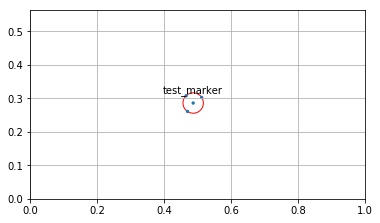

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.4703125, 0.26093749725) type 1;
offset from center:  IDNone (0.48717129387007324, 0.2860587330296043) type None;

ACTIVE MARKERS INFO


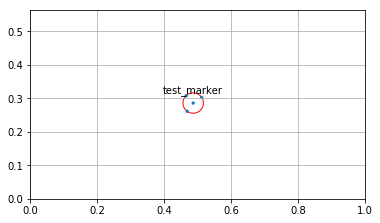

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4871587014211201, 0.28594665954002263) type None;

ACTIVE MARKERS INFO


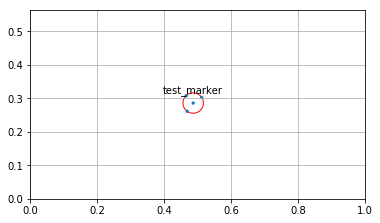

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4871587014211201, 0.28594665954002263) type None;

ACTIVE MARKERS INFO


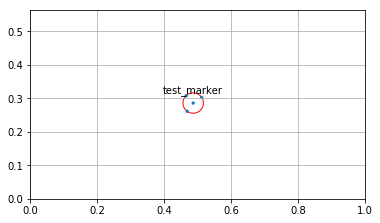

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4871587014211201, 0.28594665954002263) type None;

ACTIVE MARKERS INFO


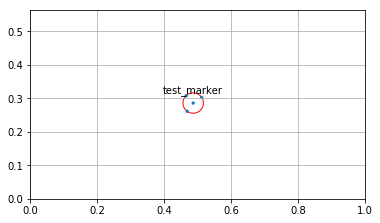

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4871587014211201, 0.28594665954002263) type None;

ACTIVE MARKERS INFO


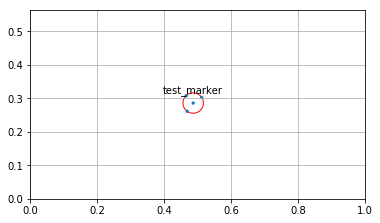

v1-v3 current: ID0 (0.5125, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4871587014211201, 0.28594665954002263) type None;

ACTIVE MARKERS INFO


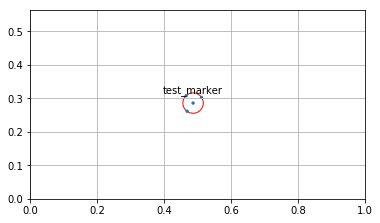

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.48687148905775407, 0.2859272970185728) type None;

ACTIVE MARKERS INFO


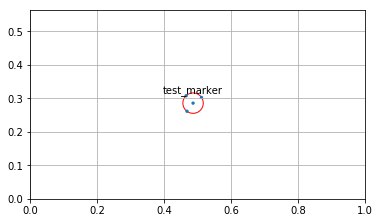

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


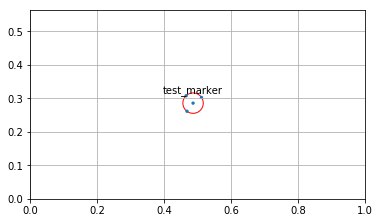

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


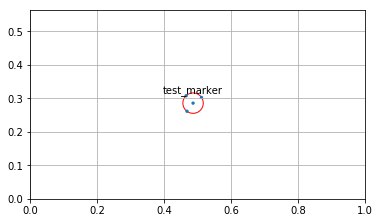

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


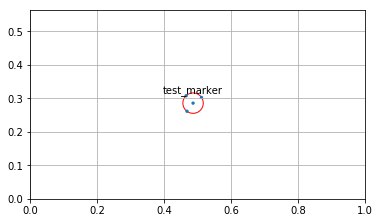

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


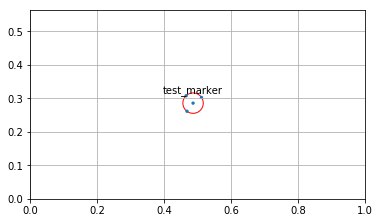

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


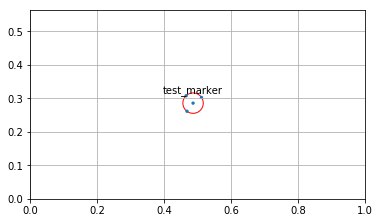

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


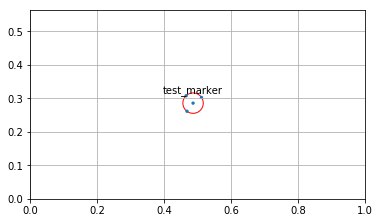

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


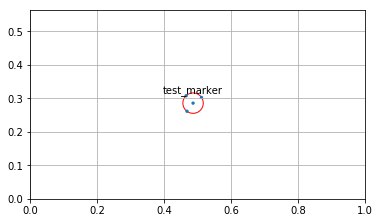

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


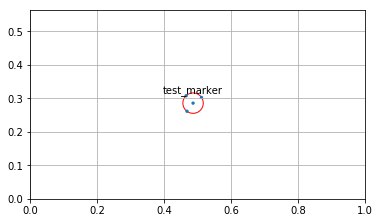

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


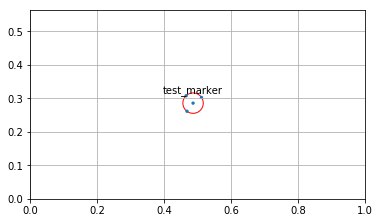

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


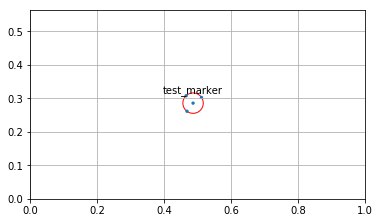

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


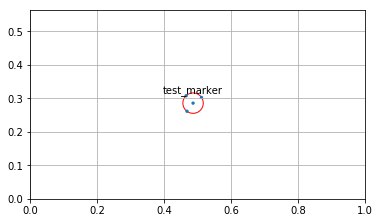

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


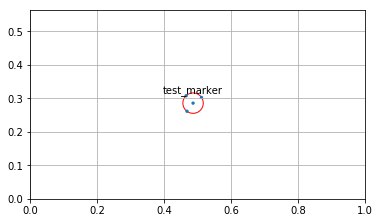

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


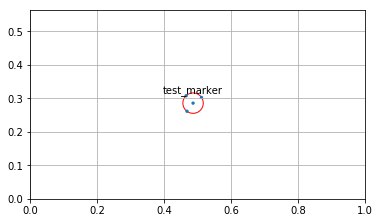

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


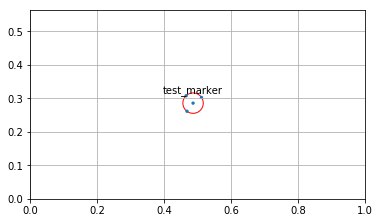

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


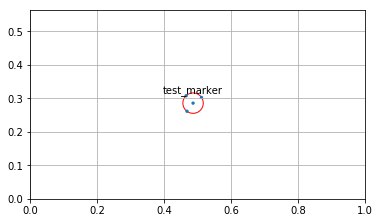

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


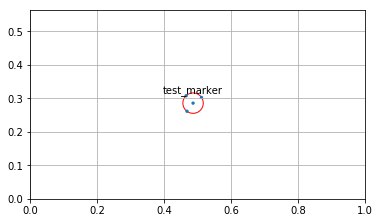

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


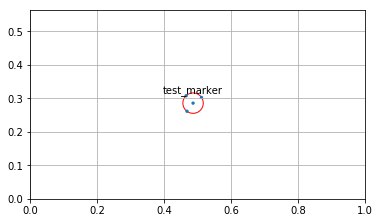

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


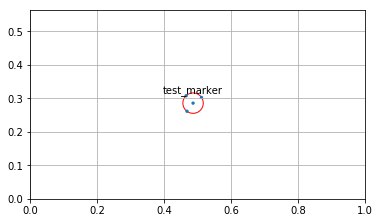

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


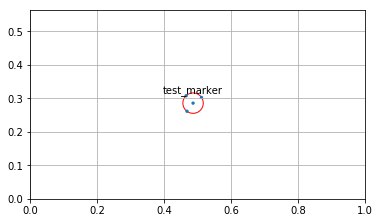

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


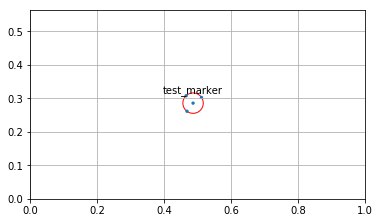

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


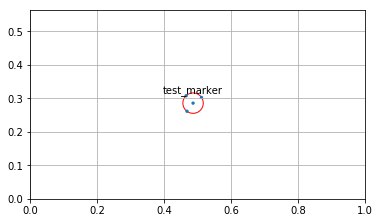

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


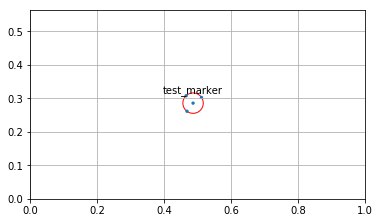

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


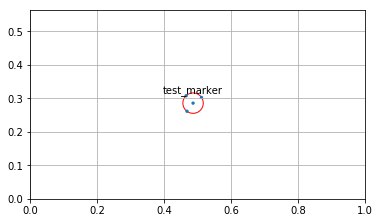

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


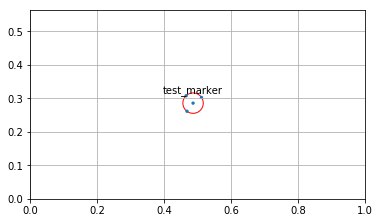

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


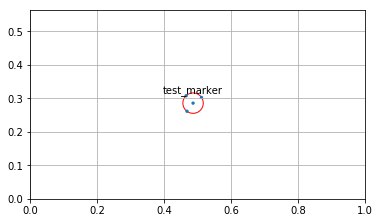

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


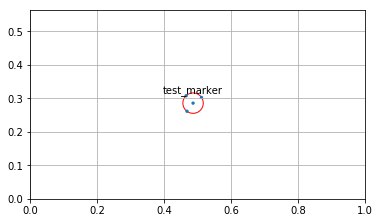

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48684853778281706, 0.2857253245652586) type None;

ACTIVE MARKERS INFO


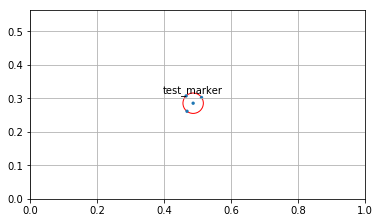

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48707249758348586, 0.28549002521459904) type None;

ACTIVE MARKERS INFO


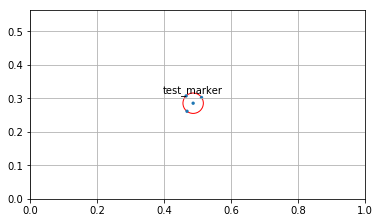

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48707249758348586, 0.28549002521459904) type None;

ACTIVE MARKERS INFO


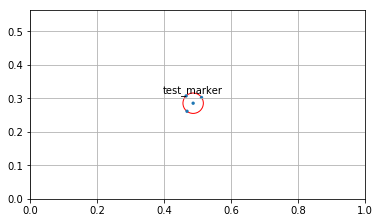

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.46875, 0.261458325) type 1;
offset from center:  IDNone (0.48707249758348586, 0.28549002521459904) type None;

ACTIVE MARKERS INFO


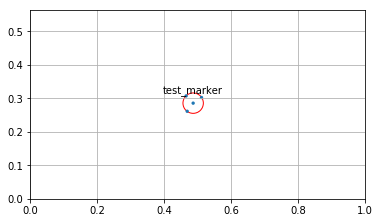

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4870936361418555, 0.2856967141075083) type None;

ACTIVE MARKERS INFO


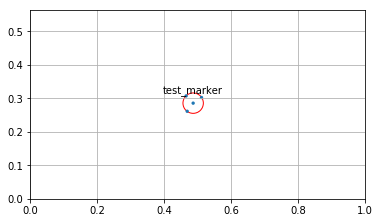

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4870936361418555, 0.2856967141075083) type None;

ACTIVE MARKERS INFO


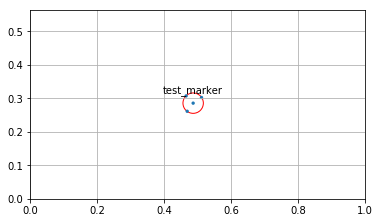

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.4870936361418555, 0.2856967141075083) type None;

ACTIVE MARKERS INFO


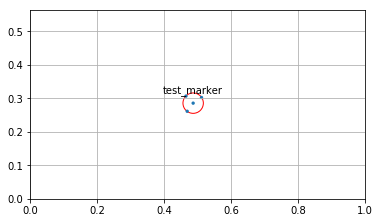

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.48709492426897233, 0.2856953770649738) type None;

ACTIVE MARKERS INFO


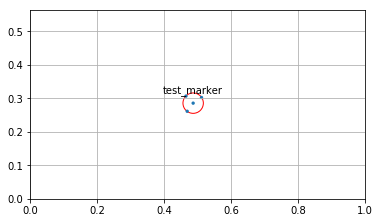

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.48709492426897233, 0.2856953770649738) type None;

ACTIVE MARKERS INFO


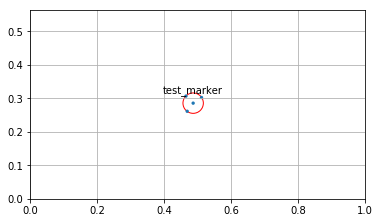

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.469270825, 0.261458325) type 1;
offset from center:  IDNone (0.48709492426897233, 0.2856953770649738) type None;

ACTIVE MARKERS INFO


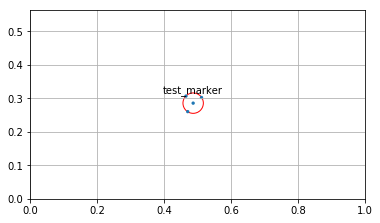

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.4870965701296073, 0.2857136872813994) type None;

ACTIVE MARKERS INFO


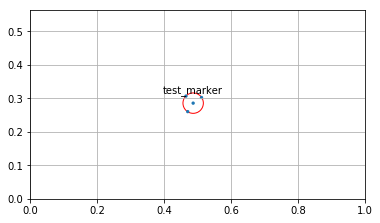

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.4870965701296073, 0.2857136872813994) type None;

ACTIVE MARKERS INFO


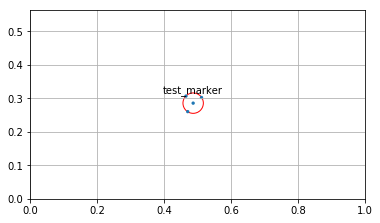

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.4870965701296073, 0.2857136872813994) type None;

ACTIVE MARKERS INFO


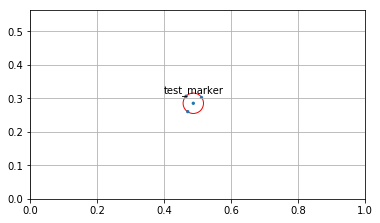

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.48753957644970425, 0.28528161966220134) type None;

ACTIVE MARKERS INFO


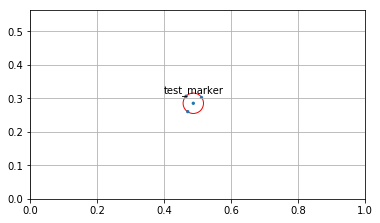

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.48753957644970425, 0.28528161966220134) type None;

ACTIVE MARKERS INFO


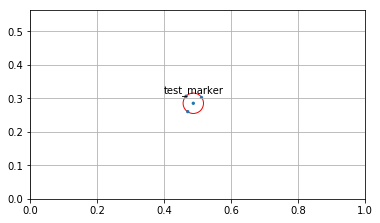

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.470833331, 0.2604166621875) type 1;
offset from center:  IDNone (0.48753957644970425, 0.28528161966220134) type None;

ACTIVE MARKERS INFO


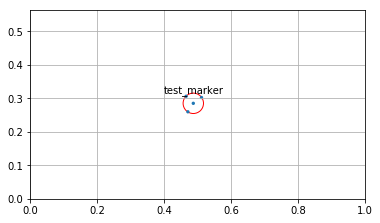

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.471354157, 0.25989582768749997) type 1;
offset from center:  IDNone (0.48753174877030475, 0.28518321397894625) type None;

ACTIVE MARKERS INFO


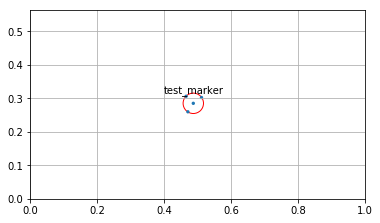

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.471354157, 0.25989582768749997) type 1;
offset from center:  IDNone (0.48753174877030475, 0.28518321397894625) type None;

ACTIVE MARKERS INFO


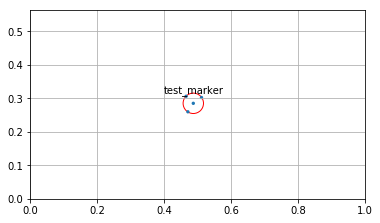

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.471354157, 0.25989582768749997) type 1;
offset from center:  IDNone (0.48753174877030475, 0.28518321397894625) type None;

ACTIVE MARKERS INFO


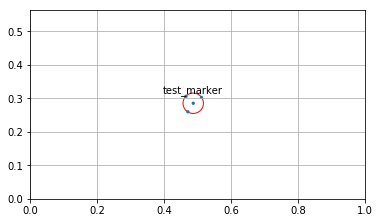

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.471354157, 0.25989582768749997) type 1;
offset from center:  IDNone (0.48730545699037614, 0.28539846703379934) type None;

ACTIVE MARKERS INFO


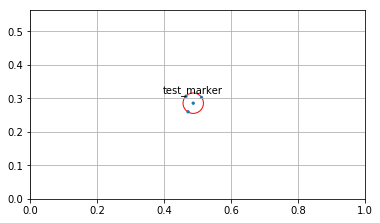

v1-v3 current: ID0 (0.511979163, 0.30260418749999995) type 1; ID1 (0.471875, 0.25989582768749997) type 1;
offset from center:  IDNone (0.4873194722398723, 0.2855766619916173) type None;

ACTIVE MARKERS INFO


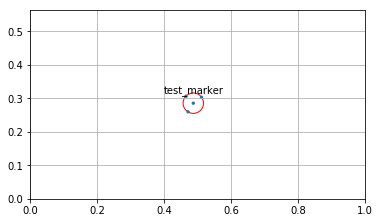

v1-v3 current: ID0 (0.511979163, 0.30312500625) type 1; ID1 (0.471875, 0.25989582768749997) type 1;
offset from center:  IDNone (0.4875154950721018, 0.28560309203397577) type None;

ACTIVE MARKERS INFO


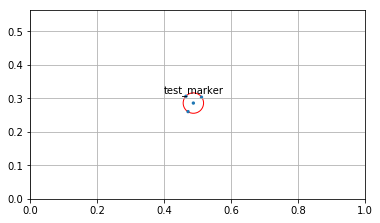

v1-v3 current: ID0 (0.511979163, 0.303645841875) type 1; ID1 (0.471875, 0.2604166621875) type 1;
offset from center:  IDNone (0.4877332107457304, 0.2859219498780749) type None;

ACTIVE MARKERS INFO


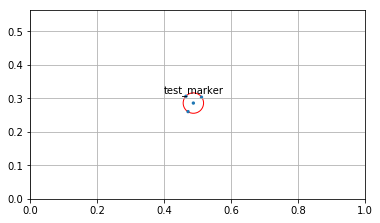

v1-v3 current: ID0 (0.511979163, 0.303645841875) type 1; ID1 (0.471875, 0.2604166621875) type 1;
offset from center:  IDNone (0.4877332107457304, 0.2859219498780749) type None;

ACTIVE MARKERS INFO


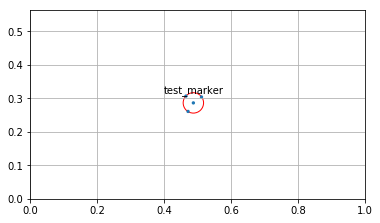

v1-v3 current: ID0 (0.511979163, 0.30416664374999997) type 1; ID1 (0.471875, 0.26093749725) type 1;
offset from center:  IDNone (0.4877331911589913, 0.2864427895045942) type None;

ACTIVE MARKERS INFO


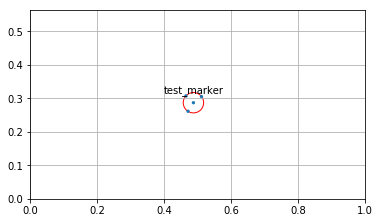

v1-v3 current: ID0 (0.511979163, 0.3052083375) type 1; ID1 (0.471875, 0.261458325) type 1;
offset from center:  IDNone (0.48793652442722407, 0.2869913405204524) type None;

ACTIVE MARKERS INFO


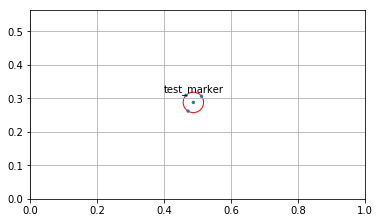

v1-v3 current: ID0 (0.511979163, 0.30624999862499996) type 1; ID1 (0.471875, 0.26197916625) type 1;
offset from center:  IDNone (0.48770047405004796, 0.2879433912720412) type None;

ACTIVE MARKERS INFO


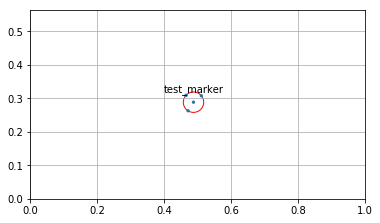

v1-v3 current: ID0 (0.511458337, 0.3078124875) type 1; ID1 (0.471875, 0.2630208375) type 1;
offset from center:  IDNone (0.488092618143126, 0.2885751270738903) type None;

ACTIVE MARKERS INFO


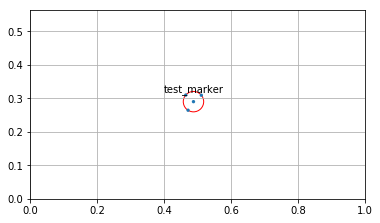

v1-v3 current: ID0 (0.511458337, 0.309375) type 1; ID1 (0.471875, 0.264583339875) type 1;
offset from center:  IDNone (0.4880624792925184, 0.2901642681368901) type None;

ACTIVE MARKERS INFO


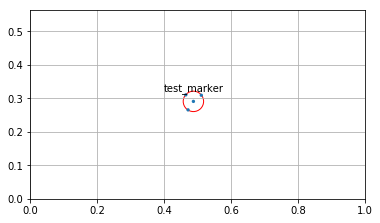

v1-v3 current: ID0 (0.511458337, 0.309375) type 1; ID1 (0.471875, 0.26562498749999996) type 1;
offset from center:  IDNone (0.4878554572190715, 0.2909482318621841) type None;

ACTIVE MARKERS INFO


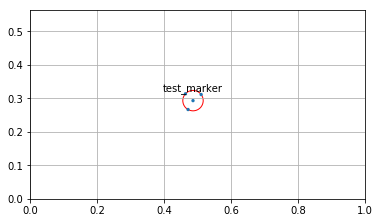

v1-v3 current: ID0 (0.5109375, 0.31145833125) type 1; ID1 (0.471875, 0.266666662125) type 1;
offset from center:  IDNone (0.48664295789683887, 0.29321653027040673) type None;

ACTIVE MARKERS INFO


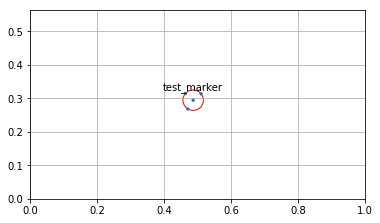

v1-v3 current: ID0 (0.5109375, 0.3135416625) type 1; ID1 (0.471354157, 0.2682291661875) type 1;
offset from center:  IDNone (0.4870641924255484, 0.2944509826501611) type None;

ACTIVE MARKERS INFO


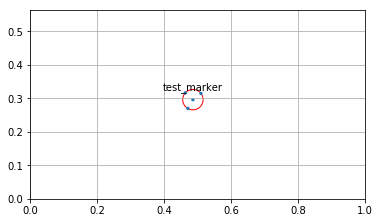

v1-v3 current: ID0 (0.5104167, 0.31458332025) type 1; ID1 (0.471354157, 0.26979167025) type 1;
offset from center:  IDNone (0.4863387714482979, 0.2961526089841077) type None;

ACTIVE MARKERS INFO


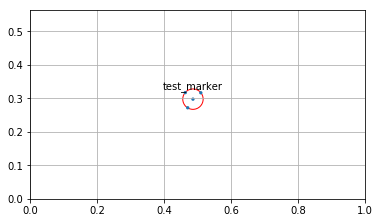

v1-v3 current: ID0 (0.509895861, 0.3166666588125) type 1; ID1 (0.470833331, 0.2718749919375) type 1;
offset from center:  IDNone (0.48650203708226614, 0.29763933863041986) type None;

ACTIVE MARKERS INFO


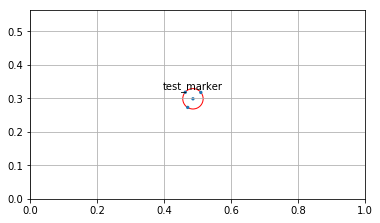

v1-v3 current: ID0 (0.509895861, 0.31770832499999996) type 1; ID1 (0.470833331, 0.2729166615) type 1;
offset from center:  IDNone (0.48650203405001663, 0.2986810094036323) type None;

ACTIVE MARKERS INFO


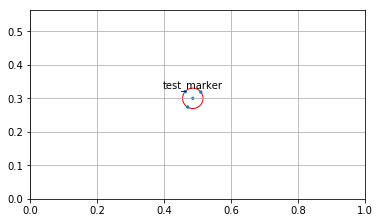

v1-v3 current: ID0 (0.509895861, 0.31874999793750003) type 1; ID1 (0.470833331, 0.2739583310625) type 1;
offset from center:  IDNone (0.4860639433011823, 0.30010473657707787) type None;

ACTIVE MARKERS INFO


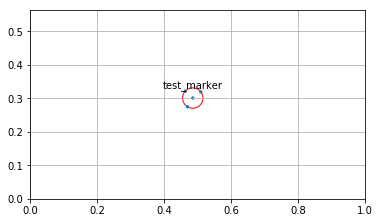

v1-v3 current: ID0 (0.509895861, 0.3192708375) type 1; ID1 (0.4703125, 0.27500000625) type 1;
offset from center:  IDNone (0.48584812402315214, 0.30094083991669424) type None;

ACTIVE MARKERS INFO


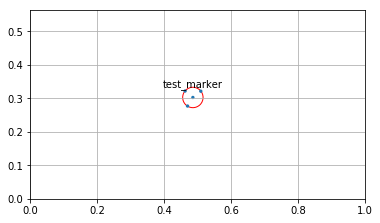

v1-v3 current: ID0 (0.509895861, 0.32135416875) type 1; ID1 (0.4703125, 0.27708333749999997) type 1;
offset from center:  IDNone (0.48624781357090485, 0.3026668014221038) type None;

ACTIVE MARKERS INFO


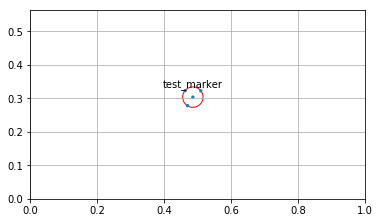

v1-v3 current: ID0 (0.509895861, 0.32239582368749997) type 1; ID1 (0.4703125, 0.278124991875) type 1;
offset from center:  IDNone (0.4862478053510148, 0.3037084633840918) type None;

ACTIVE MARKERS INFO


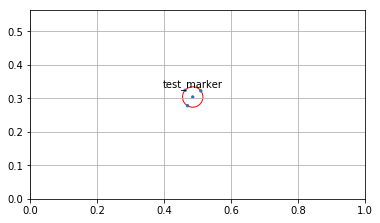

v1-v3 current: ID0 (0.509895861, 0.32239582368749997) type 1; ID1 (0.4703125, 0.278124991875) type 1;
offset from center:  IDNone (0.4858220723769904, 0.3040891190282413) type None;

ACTIVE MARKERS INFO


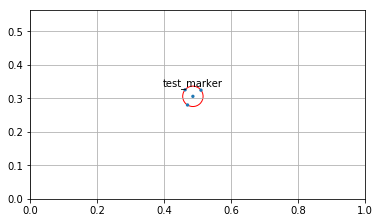

v1-v3 current: ID0 (0.5104167, 0.3244791628125) type 1; ID1 (0.4703125, 0.2802083304375) type 1;
offset from center:  IDNone (0.48630171561041985, 0.3060242450343447) type None;

ACTIVE MARKERS INFO


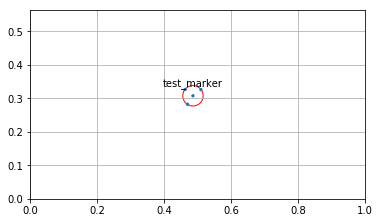

v1-v3 current: ID0 (0.5104167, 0.32604164999999996) type 1; ID1 (0.4703125, 0.2822916695625) type 1;
offset from center:  IDNone (0.48651429739180496, 0.3076961083504883) type None;

ACTIVE MARKERS INFO


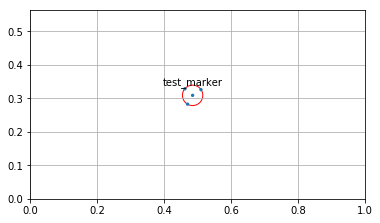

v1-v3 current: ID0 (0.5104167, 0.32604164999999996) type 1; ID1 (0.4703125, 0.2828124871875) type 1;
offset from center:  IDNone (0.4854601419651233, 0.30897699168098114) type None;

ACTIVE MARKERS INFO


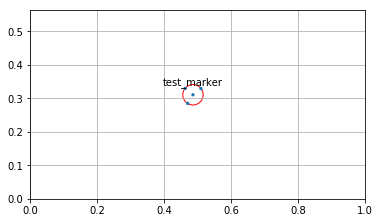

v1-v3 current: ID0 (0.5104167, 0.329166658125) type 1; ID1 (0.470833331, 0.2848958263125) type 1;
offset from center:  IDNone (0.48651305862797406, 0.31070781886106524) type None;

ACTIVE MARKERS INFO


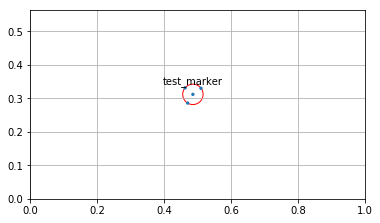

v1-v3 current: ID0 (0.5104167, 0.33020831250000005) type 1; ID1 (0.470833331, 0.28593748125) type 1;
offset from center:  IDNone (0.48630569403190954, 0.3119348820845267) type None;

ACTIVE MARKERS INFO


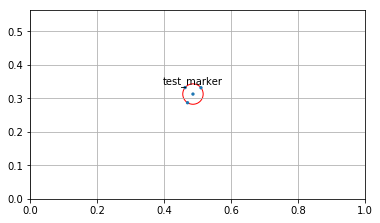

v1-v3 current: ID0 (0.5104167, 0.331770848625) type 1; ID1 (0.4703125, 0.28697917500000003) type 1;
offset from center:  IDNone (0.48650774985837036, 0.3128282404358609) type None;

ACTIVE MARKERS INFO


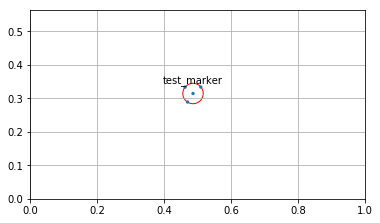

v1-v3 current: ID0 (0.509895861, 0.33385415625) type 1; ID1 (0.4703125, 0.28906250624999996) type 1;
offset from center:  IDNone (0.4866705739482785, 0.3144926844758556) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


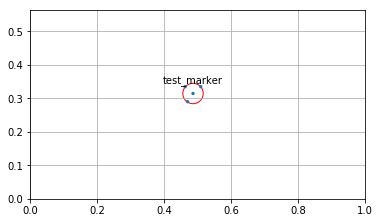

v1-v3 current: ID0 (0.509895861, 0.334895823) type 1; ID1 (0.4703125, 0.290104173) type 1;
offset from center:  IDNone (0.4866705739482785, 0.3144926844758556) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


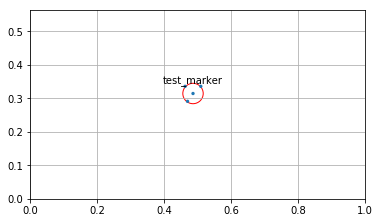

v1-v3 current: ID0 (0.509895861, 0.3359374875) type 1; ID1 (0.4703125, 0.2911458375) type 1;
offset from center:  IDNone (0.4866705739482785, 0.3144926844758556) type None;

ACTIVE MARKERS INFO


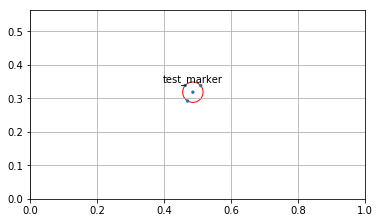

v1-v3 current: ID0 (0.509895861, 0.33802081875) type 1; ID1 (0.4703125, 0.29218751212500005) type 1;
offset from center:  IDNone (0.4862379059380603, 0.31844322502058015) type None;

ACTIVE MARKERS INFO


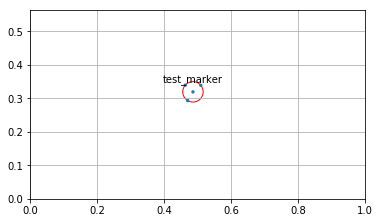

v1-v3 current: ID0 (0.509895861, 0.3390625125) type 1; ID1 (0.470833331, 0.29322916875000005) type 1;
offset from center:  IDNone (0.48649540060539215, 0.3194434521194205) type None;

ACTIVE MARKERS INFO


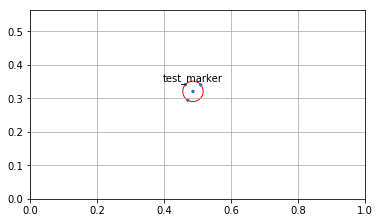

v1-v3 current: ID0 (0.509895861, 0.34010417025) type 1; ID1 (0.470833331, 0.29479168125) type 1;
offset from center:  IDNone (0.48649872088141616, 0.32078058008279936) type None;

ACTIVE MARKERS INFO


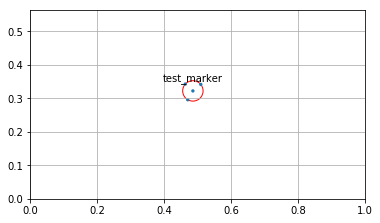

v1-v3 current: ID0 (0.509895861, 0.3416666625) type 1; ID1 (0.470833331, 0.295833337875) type 1;
offset from center:  IDNone (0.48627048628960035, 0.32223930157888175) type None;

ACTIVE MARKERS INFO


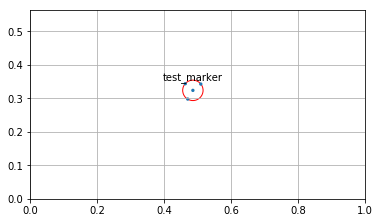

v1-v3 current: ID0 (0.509895861, 0.342708327) type 1; ID1 (0.470833331, 0.297916677) type 1;
offset from center:  IDNone (0.48628375303159965, 0.3238713807391966) type None;

ACTIVE MARKERS INFO


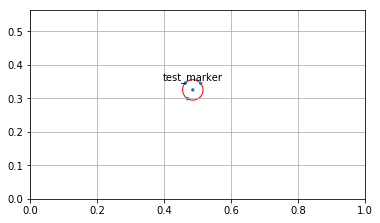

v1-v3 current: ID0 (0.509375, 0.3447916655625) type 1; ID1 (0.470833331, 0.29895834375) type 1;
offset from center:  IDNone (0.4860040217176163, 0.32532285391228694) type None;

ACTIVE MARKERS INFO


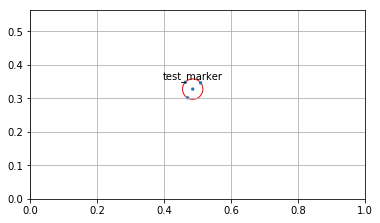

v1-v3 current: ID0 (0.509375, 0.34635414375) type 1; ID1 (0.470833331, 0.30156249375) type 1;
offset from center:  IDNone (0.4857946047304683, 0.32766654706297116) type None;

ACTIVE MARKERS INFO


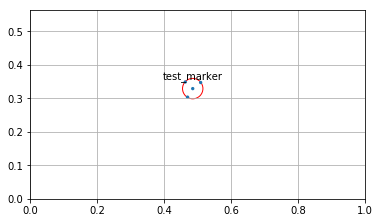

v1-v3 current: ID0 (0.509375, 0.3473958375) type 1; ID1 (0.4703125, 0.303645841875) type 1;
offset from center:  IDNone (0.48580876915973276, 0.32912350151228986) type None;

ACTIVE MARKERS INFO


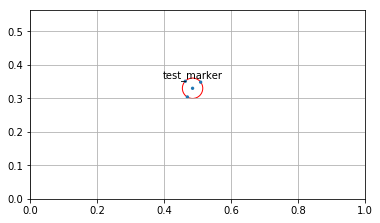

v1-v3 current: ID0 (0.509375, 0.348437491875) type 1; ID1 (0.469791681, 0.30416664374999997) type 1;
offset from center:  IDNone (0.48534210546239515, 0.330094228264758) type None;

ACTIVE MARKERS INFO


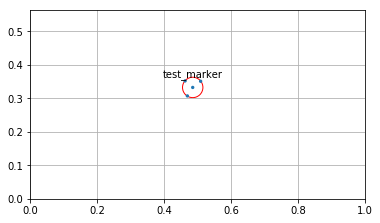

v1-v3 current: ID0 (0.509375, 0.35104168124999996) type 1; ID1 (0.469791681, 0.30729166874999997) type 1;
offset from center:  IDNone (0.4857721387452073, 0.3326149029252675) type None;

ACTIVE MARKERS INFO


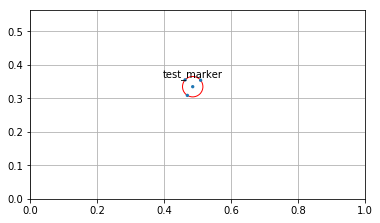

v1-v3 current: ID0 (0.509375, 0.35416665) type 1; ID1 (0.469791681, 0.308854155375) type 1;
offset from center:  IDNone (0.48575228406349347, 0.33485707186314806) type None;

ACTIVE MARKERS INFO


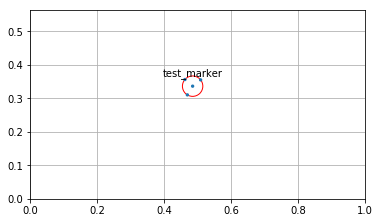

v1-v3 current: ID0 (0.509375, 0.3552083263125) type 1; ID1 (0.469791681, 0.31041667631250003) type 1;
offset from center:  IDNone (0.48550827305450345, 0.3364137237421624) type None;

ACTIVE MARKERS INFO


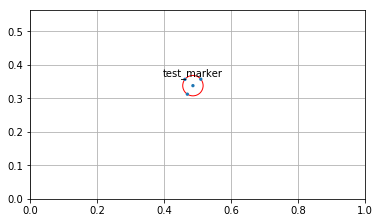

v1-v3 current: ID0 (0.509895861, 0.35729167500000003) type 1; ID1 (0.469791681, 0.312500025) type 1;
offset from center:  IDNone (0.4864073599733393, 0.3379726387846805) type None;

ACTIVE MARKERS INFO


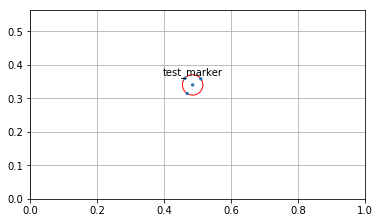

v1-v3 current: ID0 (0.509895861, 0.3583333344375) type 1; ID1 (0.469270825, 0.31458332025) type 1;
offset from center:  IDNone (0.4855737673946922, 0.34018150678347253) type None;

ACTIVE MARKERS INFO


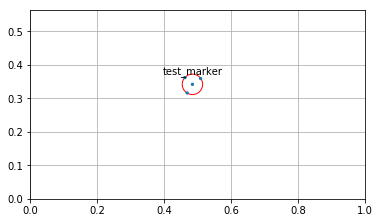

v1-v3 current: ID0 (0.509375, 0.35937500624999996) type 1; ID1 (0.469270825, 0.3161458411875) type 1;
offset from center:  IDNone (0.48489269049081035, 0.3418703897217603) type None;

ACTIVE MARKERS INFO


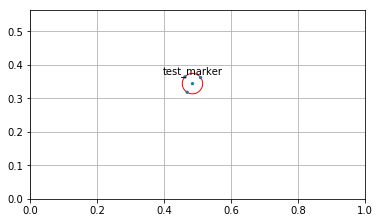

v1-v3 current: ID0 (0.509375, 0.36197915625) type 1; ID1 (0.469270825, 0.31822917975) type 1;
offset from center:  IDNone (0.4850913788403109, 0.3439830767442493) type None;

ACTIVE MARKERS INFO


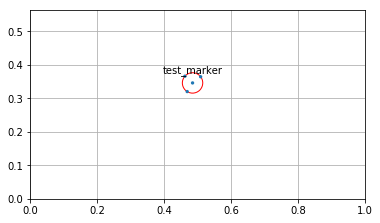

v1-v3 current: ID0 (0.509375, 0.36458330625) type 1; ID1 (0.469270825, 0.320312475) type 1;
offset from center:  IDNone (0.48529521822252536, 0.3460965087238618) type None;

ACTIVE MARKERS INFO


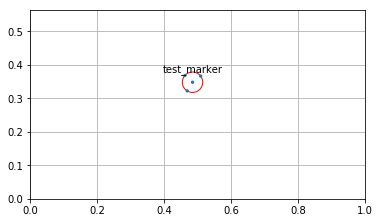

v1-v3 current: ID0 (0.509375, 0.36666665606250004) type 1; ID1 (0.469270825, 0.32239582368749997) type 1;
offset from center:  IDNone (0.4852952226385808, 0.3481798538807134) type None;

ACTIVE MARKERS INFO


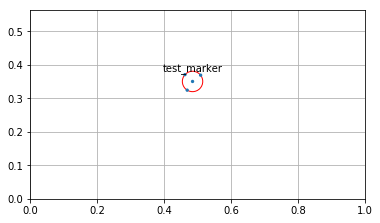

v1-v3 current: ID0 (0.509375, 0.36927084375) type 1; ID1 (0.469270825, 0.3244791628125) type 1;
offset from center:  IDNone (0.4852854330616243, 0.3504899554010747) type None;

ACTIVE MARKERS INFO


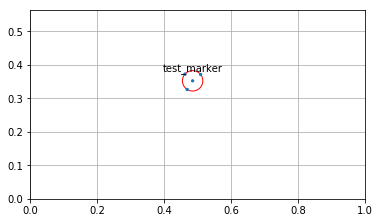

v1-v3 current: ID0 (0.509375, 0.371354151375) type 1; ID1 (0.469270825, 0.32656250137500004) type 1;
offset from center:  IDNone (0.4855042224411385, 0.35237738806153174) type None;

ACTIVE MARKERS INFO


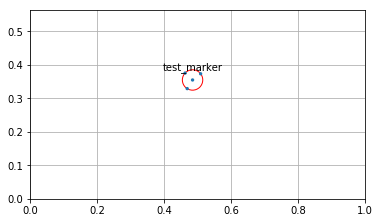

v1-v3 current: ID0 (0.509375, 0.37343750625) type 1; ID1 (0.469270825, 0.329166658125) type 1;
offset from center:  IDNone (0.48531925366945927, 0.35492892561112066) type None;

ACTIVE MARKERS INFO


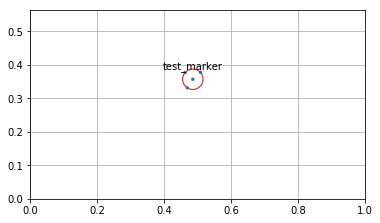

v1-v3 current: ID0 (0.508854151, 0.37760416874999997) type 1; ID1 (0.469791681, 0.33125000625) type 1;
offset from center:  IDNone (0.48616768658133985, 0.3570859868924675) type None;

ACTIVE MARKERS INFO


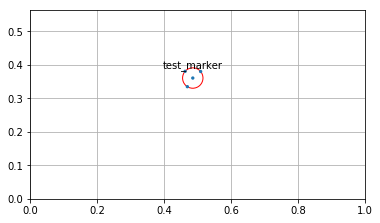

v1-v3 current: ID0 (0.509375, 0.38020831875) type 1; ID1 (0.469791681, 0.334895823) type 1;
offset from center:  IDNone (0.4859758233461518, 0.3607034643247617) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


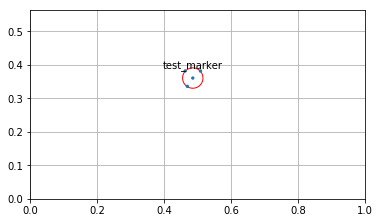

v1-v3 current: ID0 (0.508854151, 0.38177083125) type 1; ID1 (0.469791681, 0.3359374875) type 1;
offset from center:  IDNone (0.4859758233461518, 0.3607034643247617) type None;

ACTIVE MARKERS INFO


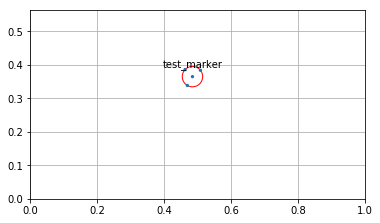

v1-v3 current: ID0 (0.508854151, 0.3838541625) type 1; ID1 (0.469791681, 0.33854169375) type 1;
offset from center:  IDNone (0.4850285874219871, 0.3648999352298066) type None;

ACTIVE MARKERS INFO


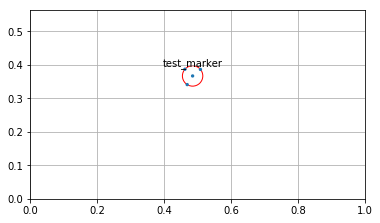

v1-v3 current: ID0 (0.508854151, 0.3864583411875) type 1; ID1 (0.469270825, 0.34114584375) type 1;
offset from center:  IDNone (0.4854550002206635, 0.36695346069795187) type None;

ACTIVE MARKERS INFO


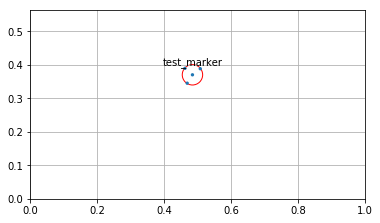

v1-v3 current: ID0 (0.5083333, 0.38854167975) type 1; ID1 (0.469270825, 0.34531248375) type 1;
offset from center:  IDNone (0.4849918250153873, 0.37037006288910523) type None;

ACTIVE MARKERS INFO


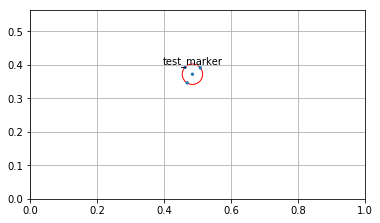

v1-v3 current: ID0 (0.5083333, 0.39114585) type 1; ID1 (0.469270825, 0.34635414375) type 1;
offset from center:  IDNone (0.4849717385811321, 0.3720903905516189) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


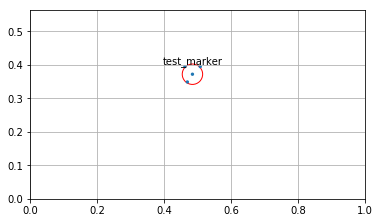

v1-v3 current: ID0 (0.5083333, 0.3947916628125) type 1; ID1 (0.469791681, 0.34895835) type 1;
offset from center:  IDNone (0.4849717385811321, 0.3720903905516189) type None;

ACTIVE MARKERS INFO


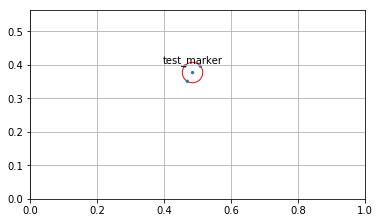

v1-v3 current: ID0 (0.5083333, 0.39635414999999996) type 1; ID1 (0.469791681, 0.35104168124999996) type 1;
offset from center:  IDNone (0.4851936205338839, 0.37698867678430714) type None;

ACTIVE MARKERS INFO


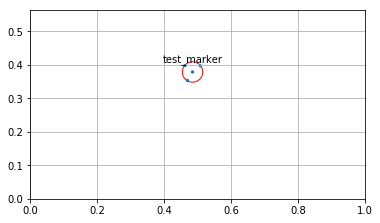

v1-v3 current: ID0 (0.5083333, 0.3973958195625) type 1; ID1 (0.4703125, 0.3531249871875) type 1;
offset from center:  IDNone (0.48520236151460144, 0.3787992157541873) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


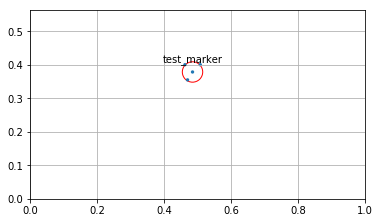

v1-v3 current: ID0 (0.5083333, 0.40052081250000005) type 1; ID1 (0.4703125, 0.3552083263125) type 1;
offset from center:  IDNone (0.48520236151460144, 0.3787992157541873) type None;

ACTIVE MARKERS INFO


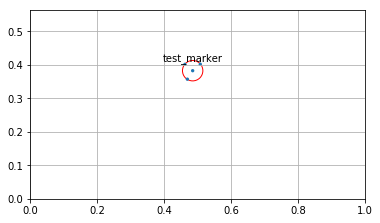

v1-v3 current: ID0 (0.5083333, 0.402083348625) type 1; ID1 (0.469791681, 0.35729167500000003) type 1;
offset from center:  IDNone (0.4856346755862917, 0.3826370228647719) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


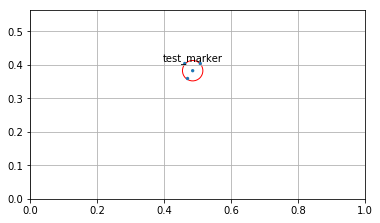

v1-v3 current: ID0 (0.5083333, 0.40416665625) type 1; ID1 (0.4703125, 0.35937500624999996) type 1;
offset from center:  IDNone (0.4856346755862917, 0.3826370228647719) type None;

ACTIVE MARKERS INFO


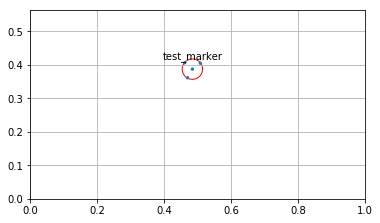

v1-v3 current: ID0 (0.5083333, 0.405208323) type 1; ID1 (0.4703125, 0.3614583375) type 1;
offset from center:  IDNone (0.4847424169072414, 0.38731398600525857) type None;

ACTIVE MARKERS INFO


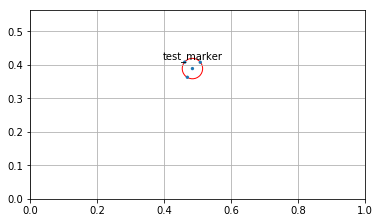

v1-v3 current: ID0 (0.5083333, 0.40781249999999997) type 1; ID1 (0.469791681, 0.36302082975) type 1;
offset from center:  IDNone (0.4849415238073347, 0.38896260829022955) type None;

ACTIVE MARKERS INFO


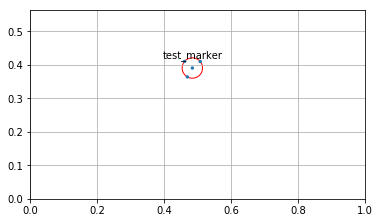

v1-v3 current: ID0 (0.5083333, 0.40989583124999995) type 1; ID1 (0.469791681, 0.3640624875) type 1;
offset from center:  IDNone (0.48467924133158524, 0.3906650680521554) type None;

ACTIVE MARKERS INFO


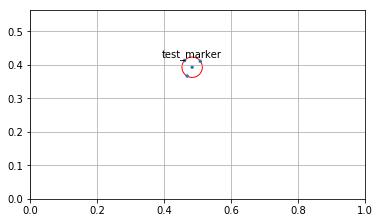

v1-v3 current: ID0 (0.5083333, 0.41093748787499995) type 1; ID1 (0.469270825, 0.36666665606250004) type 1;
offset from center:  IDNone (0.4840519940961459, 0.3929933062572698) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


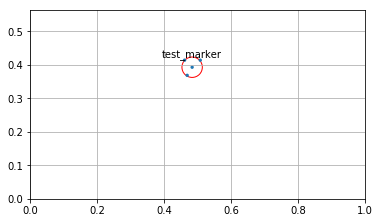

v1-v3 current: ID0 (0.5083333, 0.41406249375000004) type 1; ID1 (0.469270825, 0.368749994625) type 1;
offset from center:  IDNone (0.4840519940961459, 0.3929933062572698) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


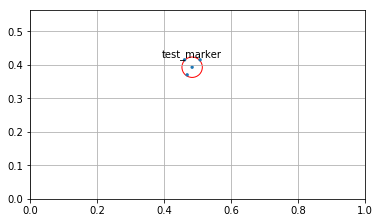

v1-v3 current: ID0 (0.5078125, 0.4151041655625) type 1; ID1 (0.469270825, 0.3703125155625) type 1;
offset from center:  IDNone (0.4840519940961459, 0.3929933062572698) type None;

ACTIVE MARKERS INFO


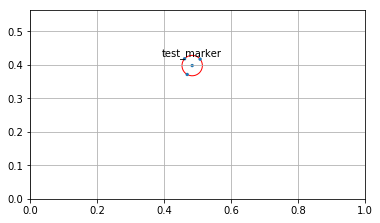

v1-v3 current: ID0 (0.5078125, 0.41718751875) type 1; ID1 (0.469270825, 0.371354151375) type 1;
offset from center:  IDNone (0.4841909466504297, 0.3979293896460964) type None;

ACTIVE MARKERS INFO


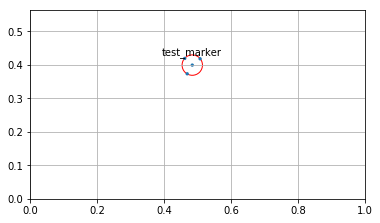

v1-v3 current: ID0 (0.5078125, 0.4182291736875) type 1; ID1 (0.469270825, 0.37343750625) type 1;
offset from center:  IDNone (0.48445492322048905, 0.3993498372579057) type None;

ACTIVE MARKERS INFO


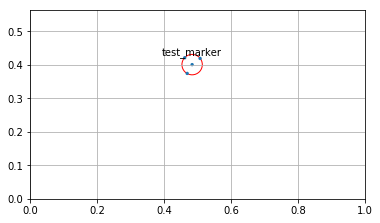

v1-v3 current: ID0 (0.5078125, 0.41927085) type 1; ID1 (0.469270825, 0.37447914374999997) type 1;
offset from center:  IDNone (0.4840078268409222, 0.400776201698508) type None;
cant update center
cant update center
cant update center

ACTIVE MARKERS INFO


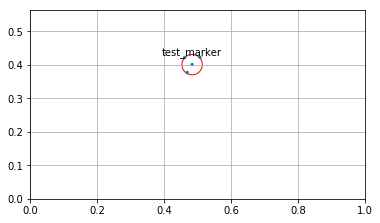

v1-v3 current: ID0 (0.5078125, 0.42239581875000004) type 1; ID1 (0.469270825, 0.37708335000000004) type 1;
offset from center:  IDNone (0.4840078268409222, 0.400776201698508) type None;

ACTIVE MARKERS INFO


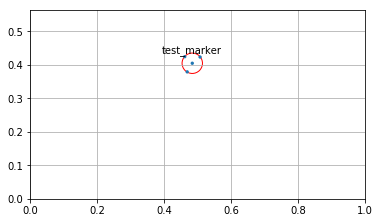

v1-v3 current: ID0 (0.5078125, 0.4234374871875) type 1; ID1 (0.469270825, 0.379166655375) type 1;
offset from center:  IDNone (0.4844616547062269, 0.40485407895644215) type None;


In [36]:
valid_cursors = {}
for data_from_frame in raw_df[:150]:
    lost_touchs = filter_touchs(data_from_frame, valid_cursors)
    delete_lost_cursors(lost_touchs, valid_cursors, markers_cursors, passive_markers, active_markers, problem_markers)
    if len(valid_cursors)>=3:
        output_search_info(passive_markers, active_markers, markers_cursors, valid_cursors, problem_markers)
    if active_markers:
        output_active_markers_info(active_markers)

In [37]:
passive_markers

{}

In [38]:
problem_markers

{}

# Черновик

In [ ]:
#m_a = (self.v2.y-self.v1.y) / (self.v2.x-self.v1.x)
#m_b = (self.v3.y-self.v2.y) / (self.v3.x-self.v2.x)
#x_center = (m_a*m_b*(self.v1.y-self.v3.y) + m_b*(self.v1.x+self.v2.x) - m_a*(self.v2.x+self.v3.x)) / (2*(m_b-m_a))
#y_center = -1/m_a * (x_center-(self.v1.x+self.v2.x)/2) + (self.v1.y+self.v2.y)/2
#self.center = Vector(x_center, y_center)

def print_all_dicts(lost_touchs, valid_cursors, suspicious_cursors, markers_cursors, passive_markers, active_markers):
    print("\n valid cursors:")
    pprint(valid_cursors)
    
    print("\n suspicious cursors:")
    pprint(suspicious_cursors)
    
    print("\n markers cursors:")
    pprint(markers_cursors)
    
    print("\n passive cursors:")
    pprint(passive_markers)
    
    print("\n active cursors:")
    pprint(active_markers)
    
    print("\n lost touchs:", lost_touchs)

# поиск маркера среди треугольников
def find_marker(t_list, marker, found_markers_dict, tolerance=EPS):
    
    for t in t_list:
        #t.pretty_print()
       
        current_mean_error = compare_triangles(t, m, tolerance)
        if current_mean_error:

            return (Marker(t.v1, t.v2, t.v3, marker.ID), current_mean_error) #+ '_current'))
            #equal_m_list.append(Marker(t.v1, t.v2, t.v3, marker.ID + '_current'))
    #return equal_m_list
    
# ищем пассивные маркеры на столе и записываем найденные в словарь
def find_all_registered_markers(passive_markers, valid_cursors):
    
    found_markers_dict = {}
    t_list = create_triangles_from_cursors(valid_cursors)
    for m in passive_markers:
        #m.pretty_print()
        current_marker, current_mean_error = find_marker(t_list, m)
        if current_marker:
            if current_marker not in found_markers_dict.values():
                found_markers_dict[m.ID] = current_marker
            else:
                #если маркер 
                chose_most_similar_marker(current_marker, found_markers_dict[m.ID])
    return found_markers_dict

def choose_most_similar_marker(applicant1, applicant2):
    